In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import mean_squared_error


In [52]:
# Load the dataset to examine its structure and contents
file_path = 'AirQualityUCI.csv'
data = pd.read_csv(file_path, delimiter=';', decimal=',', skipinitialspace=True)

# Display the first few rows and column information
data_info = {
    "head": data.head(),
    "columns": data.columns.tolist(),
    "info": data.info()
}
data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


{'head':          Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
 0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
 1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
 2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
 3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
 4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   
 
    PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
 0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
 1          955.0    103.0        1174.0     92.0        1559.0        972.0   
 2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
 3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
 4          836.0    131.0        1205.0    116.0        1490.0       1110.0   
 
       T    RH      AH  Unnamed: 15  Unnamed: 16  
 0  13.6  48.9  0.7578          NaN        

In [53]:
# Update the cleaning process: drop fully NaN columns but only drop rows with NaN in critical columns
data_cleaned = data.drop(columns=['Unnamed: 15', 'Unnamed: 16'])

# Combine 'Date' and 'Time' into a single 'Datetime' column
data_cleaned['Datetime'] = pd.to_datetime(data_cleaned['Date'] + ' ' + data_cleaned['Time'], errors='coerce')
data_cleaned = data_cleaned.drop(columns=['Date', 'Time'])

# Drop rows with NaN in the critical columns (e.g., sensor readings)
critical_columns = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'T', 'RH', 'AH']
data_cleaned = data_cleaned.dropna(subset=critical_columns)

# Reset the index after cleaning
data_cleaned = data_cleaned.reset_index(drop=True)

# Display the updated summary of the cleaned dataset
data_summary_updated = {
    "shape": data_cleaned.shape,
    "columns": data_cleaned.columns.tolist(),
    "head": data_cleaned.head()
}
data_summary_updated

C:\Users\ccoos\AppData\Local\Temp\ipykernel_24400\3086748908.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_cleaned['Datetime'] = pd.to_datetime(data_cleaned['Date'] + ' ' + data_cleaned['Time'], errors='coerce')


{'shape': (9357, 14),
 'columns': ['CO(GT)',
  'PT08.S1(CO)',
  'NMHC(GT)',
  'C6H6(GT)',
  'PT08.S2(NMHC)',
  'NOx(GT)',
  'PT08.S3(NOx)',
  'NO2(GT)',
  'PT08.S4(NO2)',
  'PT08.S5(O3)',
  'T',
  'RH',
  'AH',
  'Datetime'],
 'head':    CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
 0     2.6       1360.0     150.0      11.9         1046.0    166.0   
 1     2.0       1292.0     112.0       9.4          955.0    103.0   
 2     2.2       1402.0      88.0       9.0          939.0    131.0   
 3     2.2       1376.0      80.0       9.2          948.0    172.0   
 4     1.6       1272.0      51.0       6.5          836.0    131.0   
 
    PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  \
 0        1056.0    113.0        1692.0       1268.0  13.6  48.9  0.7578   
 1        1174.0     92.0        1559.0        972.0  13.3  47.7  0.7255   
 2        1140.0    114.0        1555.0       1074.0  11.9  54.0  0.7502   
 3        1092.0    122.0        1

In [54]:
# Example Dataset Preparation (replace this with cleaned data)
def prepare_data(data, sequence_length):
    features = data[:, :-1]
    targets = data[:, -1]
    
    sequences = []
    labels = []

    for i in range(len(features) - sequence_length):
        sequences.append(features[i:i + sequence_length])
        labels.append(targets[i + sequence_length])

    return np.array(sequences), np.array(labels)

In [55]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

# Markov Model
class MarkovModel:
    def __init__(self, states, transition_matrix):
        self.states = states
        self.transition_matrix = transition_matrix
    
    def next_state(self, current_state):
        state_idx = self.states.index(current_state)
        next_state_probabilities = self.transition_matrix[state_idx]
        return np.random.choice(self.states, p=next_state_probabilities)

    def generate_sequence(self, start_state, length):
        sequence = [start_state]
        for _ in range(length - 1):
            next_state = self.next_state(sequence[-1])
            sequence.append(next_state)
        return sequence

# Define states and transition matrix for Markov model
states = ['Sunny', 'Rainy']
transition_matrix = [
    [0.8, 0.2],  # From Sunny to Sunny and Rainy
    [0.4, 0.6]   # From Rainy to Sunny and Rainy
]

# Initialize Markov Model
markov_model = MarkovModel(states, transition_matrix)

# Generate a sequence of weather states (length 10, starting from Sunny)
sequence = markov_model.generate_sequence('Sunny', 10)
print("Generated Markov Sequence:", sequence)


Generated Markov Sequence: ['Sunny', 'Sunny', 'Sunny', 'Rainy', 'Rainy', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Rainy']


In [56]:
import numpy as np

class HiddenMarkovModel:
    def __init__(self, states, observations, start_prob, trans_prob, emit_prob):
        self.states = states
        self.observations = observations
        self.start_prob = start_prob
        self.trans_prob = trans_prob
        self.emit_prob = emit_prob
    
    def viterbi(self, obs_sequence):
        """
        Viterbi algorithm to find the most likely sequence of hidden states given an observation sequence.
        """
        n_states = len(self.states)
        n_obs = len(obs_sequence)

        # Initialize the dp table for Viterbi
        dp = np.zeros((n_states, n_obs))
        backpointer = np.zeros((n_states, n_obs), dtype=int)

        # Initialization step
        for s in range(n_states):
            dp[s, 0] = self.start_prob[s] * self.emit_prob[s, obs_sequence[0]]
        
        # Recursion step
        for t in range(1, n_obs):
            for s in range(n_states):
                max_prob = -1
                best_state = -1
                for prev_state in range(n_states):
                    prob = dp[prev_state, t-1] * self.trans_prob[prev_state, s] * self.emit_prob[s, obs_sequence[t]]
                    if prob > max_prob:
                        max_prob = prob
                        best_state = prev_state
                dp[s, t] = max_prob
                backpointer[s, t] = best_state
        
        # Backtrack to find the best path
        best_path = np.zeros(n_obs, dtype=int)
        best_path[-1] = np.argmax(dp[:, -1])
        for t in range(n_obs-2, -1, -1):
            best_path[t] = backpointer[best_path[t+1], t+1]
        
        return [self.states[state] for state in best_path]

# Define hidden states and observations
hidden_states = ['Sunny', 'Rainy']
observations = ['Walk', 'Shop', 'Clean']  # Example: Walk=0, Shop=1, Clean=2

# Define probabilities for HMM
start_prob = np.array([0.6, 0.4])  # Initial state probabilities (Sunny, Rainy)
trans_prob = np.array([
    [0.7, 0.3],  # Transition probabilities from Sunny to Sunny and Rainy
    [0.4, 0.6]   # Transition probabilities from Rainy to Sunny and Rainy
])
emit_prob = np.array([
    [0.5, 0.4, 0.1],  # Emission probabilities for Sunny (Walk, Shop, Clean)
    [0.1, 0.3, 0.6]   # Emission probabilities for Rainy (Walk, Shop, Clean)
])

# Convert observation sequence into indices
obs_sequence = [0, 1, 2, 1, 0]  # Example sequence of observations (Walk, Shop, Clean, Shop, Walk)

# Initialize HMM
hmm = HiddenMarkovModel(hidden_states, observations, start_prob, trans_prob, emit_prob)

# Decode the most likely sequence of hidden states
best_path = hmm.viterbi(obs_sequence)
print("Most Likely Hidden States:", best_path)


Most Likely Hidden States: ['Sunny', 'Sunny', 'Rainy', 'Sunny', 'Sunny']


In [57]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, pooling_type='max'):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.pooling_type = pooling_type

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        if self.pooling_type == 'max':
            self.pool = nn.MaxPool1d(kernel_size=2)
        elif self.pooling_type == 'avg':
            self.pool = nn.AvgPool1d(kernel_size=2)
        else:
            self.pool = None

    def forward(self, x):
        # Forward pass through RNN
        out, _ = self.rnn(x)
        if self.pool:
            out = self.pool(out.permute(0, 2, 1)).permute(0, 2, 1)
        out = self.fc(out[:, -1, :])  # Using last hidden state for output
        return out

# Parameters
input_size = 1  # As we only have 1 feature (state)
hidden_sizes = [16, 32, 64]
num_layers = 2
output_size = 1  # For regression or classification
sequence_length = 10  # Length of Markov generated sequence
batch_size = 32
learning_rate = 0.001
epochs_list = [5, 50, 100, 250, 350]
optimizers_list = ['sgd', 'rmsprop', 'adam']
pooling_types = ['max', 'avg']

# Convert Markov sequence into a format suitable for RNN (numerical encoding)
state_to_idx = {'Sunny': 0, 'Rainy': 1}
encoded_sequence = [state_to_idx[state] for state in sequence]
encoded_sequence = np.array(encoded_sequence).reshape(1, sequence_length, 1)  # shape: (1, sequence_length, 1)

# Prepare dataset
dataset = TensorDataset(torch.tensor(encoded_sequence, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [58]:
# Hyperparameters
input_size = 10  # Example input size (replace with actual data features)
hidden_sizes = [16, 32, 64]
num_layers = 2
output_size = 1  # Example output size (e.g., regression target)
sequence_length = 10
batch_size = 32
learning_rate = 0.001
epochs_list = [5, 50, 100, 250, 350]  # Compare different epochs
pooling_types = [None, 'max', 'avg']  # No pooling, MaxPooling, and AvgPooling
optimizers_list = ['sgd', 'rmsprop', 'adam']  # Different optimizers

In [59]:
# Example dataset (randomly generated for structure)
data = np.random.rand(1000, input_size + 1)
sequences, labels = prepare_data(data, sequence_length)

torch_sequences = torch.tensor(sequences, dtype=torch.float32)
torch_labels = torch.tensor(labels, dtype=torch.float32)

dataset = TensorDataset(torch_sequences, torch_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
import os
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

# Check for GPU availability
print("Num GPUs Available: ", torch.cuda.device_count())
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Choose first GPU (NVIDIA)
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Define a global CSV path for combined results
combined_csv_path = "combined_training_results.csv"

Num GPUs Available:  1
Using GPU: NVIDIA GeForce GTX 1650


In [61]:

# Function to save results in CSV (append mode)
def save_results_to_csv(results, header=False):
    df = pd.DataFrame(results)
    df.to_csv(combined_csv_path, mode='a', header=header, index=False)

# Initialize CSV file with header (only once)
if not os.path.exists(combined_csv_path):
    header = True
else:
    header = False

# Modify the training loop to append to a single CSV file
def train_model(model, dataloader, optimizer, criterion, epochs, scheduler, early_stopper):
    results = []
    model.to(device)  # Move model to the correct device
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the correct device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        results.append({"epoch": epoch + 1, "loss": avg_loss})

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

        # Check for early stopping
        if early_stopper(avg_loss):
            print("Early stopping triggered")
            break
        
        scheduler.step()

    # Add hyperparameters to the results before saving
    for result in results:
        result['hidden_size'] = hidden_size
        result['pooling_type'] = pooling_type
        result['optimizer'] = optimizer_name
        result['epochs'] = epochs

    # Append results to the global CSV file
    save_results_to_csv(results, header)

# Running the experiment with hyperparameters
for hidden_size in hidden_sizes:
    for pooling_type in pooling_types:
        for optimizer_name in optimizers_list:
            for epochs in epochs_list:
                model = RNNModel(input_size, hidden_size, output_size, num_layers, pooling_type)
                criterion = nn.MSELoss()

                # Select optimizer
                if optimizer_name == 'sgd':
                    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
                elif optimizer_name == 'rmsprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
                elif optimizer_name == 'adam':
                    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                # Learning rate scheduler (adjust learning rate every 10 epochs)
                scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

                # Early stopping
                early_stopper = EarlyStopping(patience=5, delta=0.01)

                print(f"\nTraining with Hidden Size: {hidden_size}, Pooling: {pooling_type}, Optimizer: {optimizer_name}, Epochs: {epochs}")
                train_model(model, dataloader, optimizer, criterion, epochs, scheduler, early_stopper)



Training with Hidden Size: 16, Pooling: None, Optimizer: sgd, Epochs: 5


c:\Users\ccoos\.conda\envs\python3.9\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\ccoos\.conda\envs\python3.9\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/5], Loss: 0.1495
Epoch [2/5], Loss: 0.1165
Epoch [3/5], Loss: 0.1014
Epoch [4/5], Loss: 0.0939
Epoch [5/5], Loss: 0.0901

Training with Hidden Size: 16, Pooling: None, Optimizer: sgd, Epochs: 50
Epoch [1/50], Loss: 0.0906
Epoch [2/50], Loss: 0.0885
Epoch [3/50], Loss: 0.0878
Epoch [4/50], Loss: 0.0869
Epoch [5/50], Loss: 0.0866
Epoch [6/50], Loss: 0.0863
Epoch [7/50], Loss: 0.0861
Epoch [8/50], Loss: 0.0861
Epoch [9/50], Loss: 0.0859
Epoch [10/50], Loss: 0.0859
Epoch [11/50], Loss: 0.0859
Epoch [12/50], Loss: 0.0859
Epoch [13/50], Loss: 0.0858
Epoch [14/50], Loss: 0.0858
Epoch [15/50], Loss: 0.0857
Epoch [16/50], Loss: 0.0859
Epoch [17/50], Loss: 0.0859
Epoch [18/50], Loss: 0.0858
Epoch [19/50], Loss: 0.0859
Epoch [20/50], Loss: 0.0858
Epoch [21/50], Loss: 0.0857
Epoch [22/50], Loss: 0.0858
Epoch [23/50], Loss: 0.0858
Epoch [24/50], Loss: 0.0859
Epoch [25/50], Loss: 0.0859
Epoch [26/50], Loss: 0.0859
Epoch [27/50], Loss: 0.0858
Epoch [28/50], Loss: 0.0858
Epoch [29/50], Loss: 

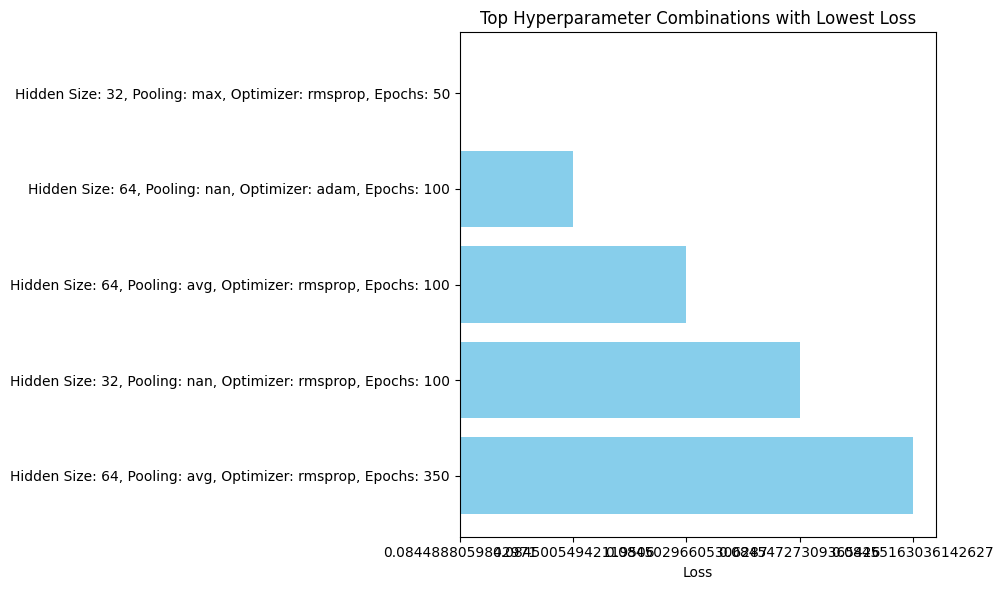

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the training results CSV file
df = pd.read_csv("combined_training_results.csv")

# Sort by the lowest loss (ascending) and select the top 5 best configurations
top_5_results = df.sort_values(by='loss').head(5)

# Prepare data for the bar plot
hyperparameters = []
loss_values = []

# Iterate over the top 5 results and store the hyperparameter configurations and loss values
for index, row in top_5_results.iterrows():
    config = f"Hidden Size: {row['hidden_size']}, Pooling: {row['pooling_type']}, Optimizer: {row['optimizer']}, Epochs: {row['epochs']}"
    hyperparameters.append(config)
    loss_values.append(row['loss'])

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(hyperparameters, loss_values, color='skyblue')
plt.xlabel('Loss')
plt.title('Top Hyperparameter Combinations with Lowest Loss')
plt.gca().invert_yaxis()  # Invert the y-axis to show the best result on top
plt.tight_layout()
plt.show()
